# Notes

- Data taken from here: https://github.com/alibashir/aav (File: allseqs_20191230.csv.zip)
- Data exists as well here: https://www.dropbox.com/sh/lmd8wmgibz24r2h/AADmgvc_0Q5mylwgGf97cTC-a/ML_and_Analysis/model_and_dataset_analysis/allseqs_20191230.csv.zip?dl=0
- [This repository](https://github.com/google-research/google-research/tree/master/aav/model_training) suggest that the wild type AA sequence is 28 residues and is `DEEEIRTTNPVATEQYGSVSTNLQRGNR`
- The UniProt sequence is here: https://www.uniprot.org/uniprot/P03135
- In UniProt notation (sequence starts at 1), the region on P03135 where the sequence mutates is `[561, 588]`

In [1]:
# In order to process the data (and further notebooks, with indices 1_, 2_,..) we need to install some dependencies! 
!pip install biopython
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

In [2]:
import pandas
import math
import random
import numpy

from pathlib import Path
from pandas import read_csv, DataFrame
from sklearn.model_selection import train_test_split

from flip import read_fasta, plot_data_statistics, print_positive_stats

In [3]:
# By setting a random seed, we make sure that random sampling happens the same way acrosss different runs
random.seed(11)

In [4]:
# Let's define where the RAW data is and where to store the processed data
data_path = Path('') / '..' / 'data' / 'aav'
aav_data_path = data_path / 'allseqs_20191230.csv'

split_path = Path('') / '..' / 'splits' / 'aav'

In [5]:
# Let's load the RAW data
aav_data = read_csv(aav_data_path)

In [6]:
# What columns are available in the dataframe?
for column_name in aav_data.columns:
    print(column_name)

sequence
partition
mutation_sequence
num_mutations
num_edits
viral_selection
is_viable


In [7]:
# Let's load the wild type protein sequence, and define the region which is mutated in the AAV set
P03135 = read_fasta(data_path / 'P03135.fasta')[0]
region = (561,588)
reference_region = "DEEEIRTTNPVATEQYGSVSTNLQRGNR"

In [8]:
# Get the wild type sequence from the RAW data
wt = aav_data[aav_data['partition'] == "wild_type"].to_dict(orient='records')[0]

In [9]:
# Make sure that the wild type from the RAW data matches the UniProt sequence from P03135
assert(wt['sequence'] == reference_region)

# Important: region[0] -1 because UniProt notation! (0 in Python == 1 in UniProt)
assert(wt['sequence'] == str(P03135[region[0]-1 : region[1]].seq))

# Make sure chopping the sequence works as expected:

assert(
    str(P03135.seq) ==
    str(P03135[:region[0]-1].seq) + str(P03135[region[0]-1 : region[1]].seq) + str(P03135[region[1]:].seq)
)

In [10]:
# Remove data where scores are +/- inf
aav_data.replace([math.inf, -math.inf], math.nan, inplace=True)
aav_data.dropna(inplace=True)

Based on the the manuscript:
 
> To avoid overfitting to experimental noise, rather than predicting the quantitative production efficiency we used binary classification models to predict whether each sequence variant is viable (Supplementary Fig. 1), as defined by a threshold fit to best separate positive and negative controls (WT replicas, and variants containing stop codons, respectively).

In other words, by plotting `viral_selection`, one should see a binomial. In order to have a visual verification, let's plot the viral_selection!

<AxesSubplot:>

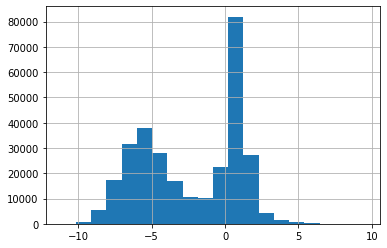

In [11]:
aav_data['viral_selection'].hist(bins=20)

In [12]:
# What are the sequence partitions (e.g.: designed via machine learning vs. measured in the lab)
for partition in aav_data['partition'].unique():
    print(partition)

designed
rand
single
stop
cnn_designed_plus_rand_train_walked
lr_rand_doubles_plus_single_walked
cnn_rand_doubles_plus_single_seed
cnn_standard_walked
rnn_rand_doubles_plus_singles_seed
lr_standard_walked
lr_rand_doubles_plus_single_seed
lr_designed_plus_rand_train_seed
cnn_rand_doubles_plus_single_walked
previous_chip_nonviable
cnn_designed_plus_rand_train_seed
lr_standard_seed
rnn_designed_plus_rand_train_walked
lr_designed_plus_rand_train_walked
random_doubles
rnn_standard_seed
previous_chip_viable
rnn_standard_walked
rnn_designed_plus_rand_train_seed
cnn_standard_seed
rnn_rand_doubles_plus_singles_walked
singles
wild_type


In [13]:
aav_data['partition'].value_counts()

designed                                56326
random_doubles                          25040
rnn_standard_walked                     20838
cnn_designed_plus_rand_train_walked     20759
rnn_designed_plus_rand_train_walked     20731
lr_standard_walked                      20456
cnn_rand_doubles_plus_single_walked     20454
cnn_standard_walked                     20395
rnn_rand_doubles_plus_singles_walked    20154
lr_rand_doubles_plus_single_walked      19999
lr_designed_plus_rand_train_walked      19680
rand                                     9857
lr_rand_doubles_plus_single_seed         2071
rnn_designed_plus_rand_train_seed        2065
rnn_rand_doubles_plus_singles_seed       2045
lr_designed_plus_rand_train_seed         2030
cnn_rand_doubles_plus_single_seed        2022
lr_standard_seed                         1989
cnn_standard_seed                        1924
rnn_standard_seed                        1916
cnn_designed_plus_rand_train_seed        1898
single                            

In [14]:
# Let's define the partitions that we consider to be part of the "natural" sequences (with associated experiments)
# vs. the designed sequences (which were predicted using ML).

natural_partitions = [
    'previous_chip_viable',
    'previous_chip_nonviable', 
    'stop',
    'single',
    'singles',
    'wild_type',
    'random_doubles',
    'designed',
]

design_partitions = [
    'cnn_designed_plus_rand_train_walked',
    'lr_rand_doubles_plus_single_walked',
    'cnn_rand_doubles_plus_single_seed',
    'cnn_standard_walked',
    'rnn_rand_doubles_plus_singles_seed',
    'lr_standard_walked',
    'lr_rand_doubles_plus_single_seed',
    'lr_designed_plus_rand_train_seed',
    'cnn_rand_doubles_plus_single_walked',
    'cnn_designed_plus_rand_train_seed',
    'lr_standard_seed',
    'rnn_designed_plus_rand_train_walked',
    'lr_designed_plus_rand_train_walked',
    'rnn_standard_seed',
    'rnn_standard_walked',
    'rnn_designed_plus_rand_train_seed',
    'cnn_standard_seed',
    'rnn_rand_doubles_plus_singles_walked',
]

In [15]:
aav_data.loc[aav_data.partition.isin(natural_partitions), 'overarching_partition'] = "natural_partitions"
aav_data.loc[aav_data.partition.isin(design_partitions), 'overarching_partition'] = "design_partitions"

In [16]:
# De-duplicate (ie.: redundancy reduction at 100% similarity and coverage) sequences in the two categories (natural vs
# design) separately. It could happen, that sequences in natural are also present in design. We will take care of this
# later.

def aggregate_rows(dataframe_slice):
    first_element = dataframe_slice.iloc[0]
    return {
        'mutation_mask': first_element.mutation_sequence,
        'mutated_region': first_element.sequence,
        'category': first_element.partition,
        'number_of_mutations': first_element.num_mutations,
        'levenshtein_distance': first_element.num_edits,
        'binary_score': first_element.is_viable,
        'overarching_partition': first_element.overarching_partition,
        'score': dataframe_slice.viral_selection.mean()
    }

grouped_protein_data = aav_data.groupby(['sequence', 'overarching_partition']).apply(aggregate_rows).values
protein_data = DataFrame.from_records(grouped_protein_data)

In [17]:
# We want to insert the mutated region for each sample into the complete protein sequence, ie.
# [beginning_of_sequence] + [variable_region] + [end_of_seqeuence]
def region_cut(new_sequence):
    filtered_sequence = new_sequence.upper().replace('*','')
    return str(P03135[:region[0]-1].seq) + filtered_sequence + str(P03135[region[1]:].seq)

protein_data['full_aa_sequence'] = protein_data['mutated_region'].apply(region_cut)

The test set will be 20.00% of the data (16517 out of 82583 samples).
Set sampled_split has 66066 train and 16517 test sequences. 49% of test is positive.


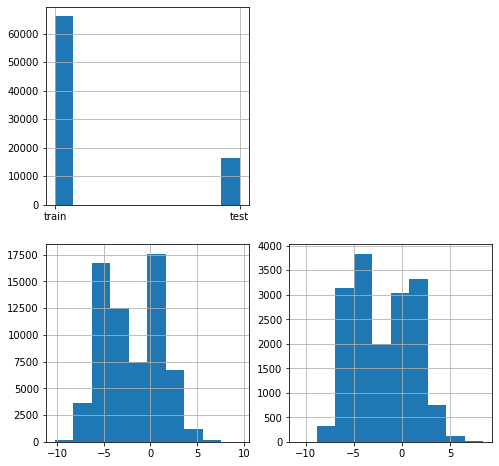

In [18]:
# Randomly pick 80% of data for training and 20% for testing for the sequences in the natural partitions
natural_partitions_indices = protein_data[protein_data.overarching_partition == 'natural_partitions'].index
train_indices, test_indeces = train_test_split(natural_partitions_indices, test_size=0.2, random_state=11)

protein_data.loc[train_indices, 'sampled_split'] = 'train'
protein_data.loc[test_indeces, 'sampled_split'] = 'test'

# Plot and print split statistics
plot_data_statistics(protein_data, 'sampled_split', 'score')
print_positive_stats(protein_data, 'sampled_split')

# Randomly pick 10% of train for validation
train_indices = protein_data.query('sampled_split=="train"').index
_, val_indices = train_test_split(train_indices, test_size=0.1, random_state=11)
protein_data.loc[val_indices, 'sampled_split_validation'] = True

# Store split
split = protein_data[protein_data.notna()]
split = split.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'sampled_split': 'set',
    'sampled_split_validation': 'validation'
}, axis=1)

split[
    ['sequence', 'target', 'set', 'validation']
].to_csv(split_path / 'splits' / "sampled.csv", index=False)

The test set will be 98.58% of the data (81413 out of 82583 samples).
Set one_vs_many_split has 1170 train and 81413 test sequences. 49% of test is positive.


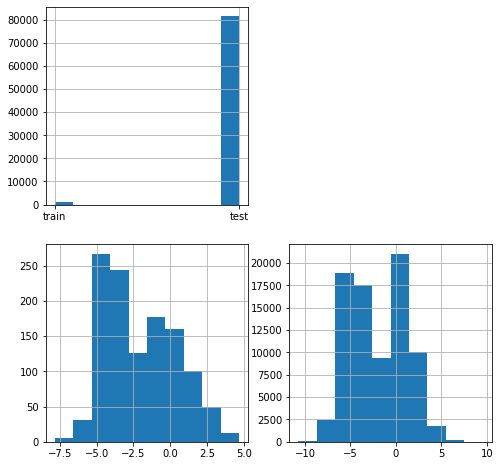

In [19]:
# one-vs-many: train on single and WT, test on everything else
num_mutations_threshold = 1
protein_data['one_vs_many_split'] = protein_data[
    protein_data.overarching_partition == 'natural_partitions'
].levenshtein_distance.apply(lambda x: "train" if x <= num_mutations_threshold else "test")

# Plot and print split statistics
plot_data_statistics(protein_data, 'one_vs_many_split', 'score')
print_positive_stats(protein_data, 'one_vs_many_split')

# Randomly pick 10% of train for validation
train_indices = protein_data.query('one_vs_many_split=="train"').index
_, val_indices = train_test_split(train_indices, test_size=0.1, random_state=11)
protein_data.loc[val_indices, 'one_vs_many_split_validation'] = True

# Store split
split = protein_data[protein_data.notna()]
split = split.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'one_vs_many_split': 'set',
    'one_vs_many_split_validation': 'validation'
}, axis=1)

split[
    ['sequence', 'target', 'set', 'validation']
].to_csv(split_path / 'splits' / "one_vs_many.csv", index=False)

The test set will be 61.48% of the data (50776 out of 82583 samples).
Set two_vs_many_split has 31807 train and 50776 test sequences. 59% of test is positive.


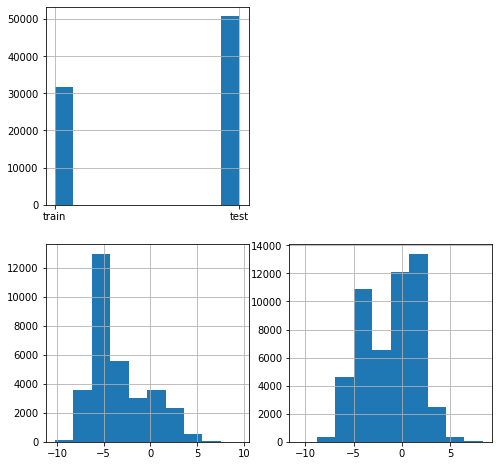

In [20]:
# two-vs-many: train on single and WT, test on everything else
num_mutations_threshold = 2
protein_data['two_vs_many_split'] = protein_data[
    protein_data.overarching_partition == 'natural_partitions'
].levenshtein_distance.apply(lambda x: "train" if x <= num_mutations_threshold else "test")

# Plot and print split statistics
plot_data_statistics(protein_data, 'two_vs_many_split', 'score')
print_positive_stats(protein_data, 'two_vs_many_split')

# Randomly pick 10% of train for validation
train_indices = protein_data.query('two_vs_many_split=="train"').index
_, val_indices = train_test_split(train_indices, test_size=0.1, random_state=11)
protein_data.loc[val_indices, 'two_vs_many_split_validation'] = True

# Store split
split = protein_data[protein_data.notna()]
split = split.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'two_vs_many_split': 'set',
    'two_vs_many_split_validation': 'validation'
}, axis=1)

split[
    ['sequence', 'target', 'set', 'validation']
].to_csv(split_path / 'splits' / "two_vs_many.csv", index=False)

The test set will be 15.23% of the data (12581 out of 82583 samples).
Set seven_vs_many_split has 70002 train and 12581 test sequences. 17% of test is positive.


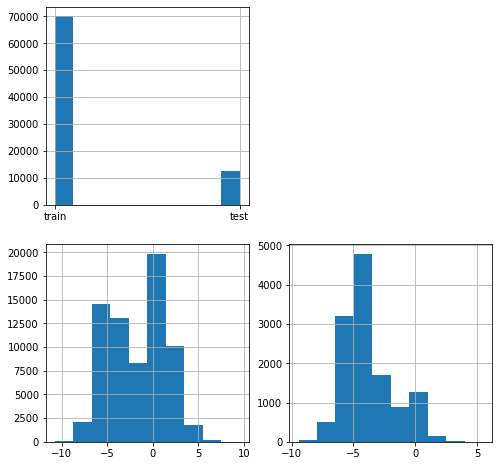

In [21]:
# seven-vs-many: train on single and WT, test on everything else
num_mutations_threshold = 7
protein_data['seven_vs_many_split'] = protein_data[
    protein_data.overarching_partition == 'natural_partitions'
].levenshtein_distance.apply(lambda x: "train" if x <= num_mutations_threshold else "test")

# Plot and print split statistics
plot_data_statistics(protein_data, 'seven_vs_many_split', 'score')
print_positive_stats(protein_data, 'seven_vs_many_split')

# Randomly pick 10% of train for validation
train_indices = protein_data.query('seven_vs_many_split=="train"').index
_, val_indices = train_test_split(train_indices, test_size=0.1, random_state=11)
protein_data.loc[val_indices, 'seven_vs_many_split_validation'] = True

# Store split
split = protein_data[protein_data.notna()]
split = split.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'seven_vs_many_split': 'set',
    'seven_vs_many_split_validation': 'validation'
}, axis=1)

split[
    ['sequence', 'target', 'set', 'validation']
].to_csv(split_path / 'splits' / "seven_vs_many.csv", index=False)

The test set will be 42.43% of the data (35037 out of 82583 samples).
Set low_vs_high_split has 47546 train and 35037 test sequences. 100% of test is positive.


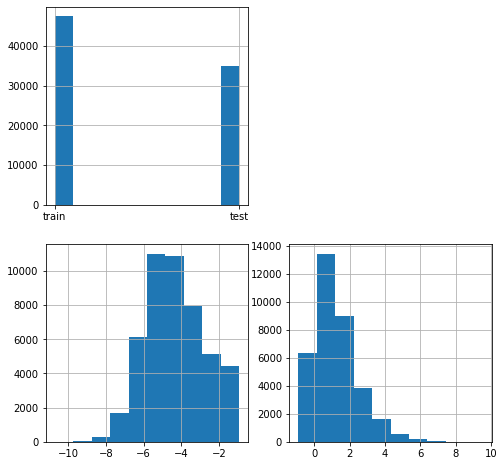

In [22]:
# low-vs-high: train when fitness is below or equal to wild type, test when above

score_threshold = wt['viral_selection']

protein_data['low_vs_high_split'] = protein_data[
    protein_data.overarching_partition == 'natural_partitions'
].score.apply(lambda x: "train" if x <= score_threshold else "test")

# Plot and print split statistics
plot_data_statistics(protein_data, 'low_vs_high_split', 'score')
print_positive_stats(protein_data, 'low_vs_high_split')

# Randomly pick 10% of train for validation
train_indices = protein_data.query('low_vs_high_split=="train"').index
_, val_indices = train_test_split(train_indices, test_size=0.1, random_state=11)
protein_data.loc[val_indices, 'low_vs_high_split_validation'] = True

# Store split
split = protein_data[protein_data.notna()]
split = split.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'low_vs_high_split': 'set',
    'low_vs_high_split_validation': 'validation'
}, axis=1)

split[
    ['sequence', 'target', 'set', 'validation']
].to_csv(split_path / 'splits' / "low_vs_high.csv", index=False)

The test set will be 70.92% of the data (201426 out of 284009 samples).
Set mut_des_split has 82583 train and 201426 test sequences. 55% of test is positive.


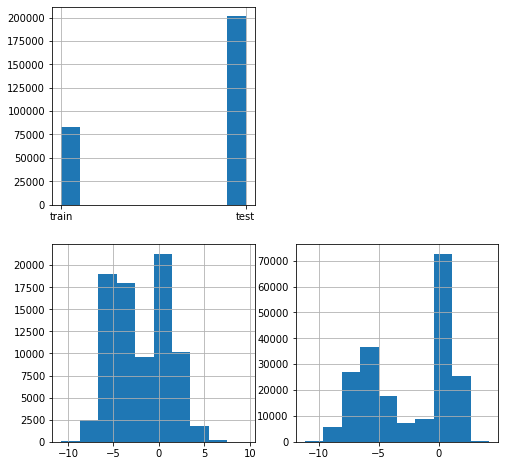

In [23]:
# Use the sequences in natural partitions for training
def mut_des_split(overarching_partition):
    if overarching_partition in 'natural_partitions':
        return "train"
    elif overarching_partition in 'design_partitions':
        return "test"
    else:
        return None

protein_data['mut_des_split'] = protein_data.overarching_partition.apply(mut_des_split)

# Plot and print split statistics
plot_data_statistics(protein_data, 'mut_des_split', 'score')
print_positive_stats(protein_data, 'mut_des_split')

# Randomly pick 10% of train for validation
train_indices = protein_data.query('mut_des_split=="train"').index
_, val_indices = train_test_split(train_indices, test_size=0.1, random_state=11)
protein_data.loc[val_indices, 'mut_des_split_validation'] = True

# Store split
split = protein_data[protein_data.notna()]
split = split.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'mut_des_split': 'set',
    'mut_des_split_validation': 'validation'
}, axis=1)

split[
    ['sequence', 'target', 'set', 'validation']
].to_csv(split_path / 'splits' / "mut_des.csv", index=False)

The test set will be 29.08% of the data (82583 out of 284009 samples).
Set des_mut_split has 201426 train and 82583 test sequences. 49% of test is positive.


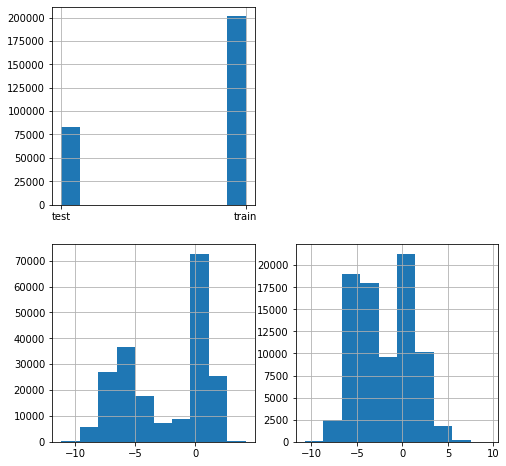

In [24]:
def des_mut_split(overarching_partition):
    if overarching_partition in 'design_partitions':
        return "train"
    elif overarching_partition in 'natural_partitions':
        return "test"
    else:
        return None
    
protein_data['des_mut_split'] = protein_data.overarching_partition.apply(des_mut_split)

# Plot and print split statistics
plot_data_statistics(protein_data, 'des_mut_split', 'score')
print_positive_stats(protein_data, 'des_mut_split')

# Randomly pick 10% of train for validation
train_indices = protein_data.query('des_mut_split=="train"').index
_, val_indices = train_test_split(train_indices, test_size=0.1, random_state=11)
protein_data.loc[val_indices, 'des_mut_split_validation'] = True

# Store split
split = protein_data[protein_data.notna()]
split = split.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'des_mut_split': 'set',
    'des_mut_split_validation': 'validation'
}, axis=1)

split[
    ['sequence', 'target', 'set', 'validation']
].to_csv(split_path / 'splits' / "des_mut.csv", index=False)

In [25]:
# Add reference region for completeness
protein_data['reference_region'] = reference_region

protein_data.to_csv(split_path / "full_data.csv", index=False)